#### Importing libraries and loading the datasets

In [436]:
import pandas as pd
import numpy as np
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import shap
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import plotly.express as px
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [437]:
import pandas as pd

# Define column names as per the Adult Income dataset
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race',
    'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
    'native_country', 'income'
]

# Load training dataset
train_df = pd.read_csv(
    'C:\\Users\\rroha\\OneDrive\\Desktop\\Bits_Pilani_LF_Raj\\Web_1_EDA_Python\\adult-training.csv',
    names=columns,
    na_values='?',
    header=None,
    sep=', '
)

# Load test dataset
test_df = pd.read_csv(
    'C:\\Users\\rroha\\OneDrive\\Desktop\\Bits_Pilani_LF_Raj\\Web_1_EDA_Python\\adult-test.csv',
    names=columns,
    na_values='?',
    header=None,
    sep=', '
)

In [438]:
train_df.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [439]:
test_df.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,|1x3 Cross validator,None,NaN,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.


In [440]:
train_df.shape # The training census data has information about income details for 32,561 people.

(32561, 15)

In [441]:
test_df.shape # The test census data has information about income details for 16,282 people.

(16282, 15)

In [442]:
# Combine train and test datasets for unified EDA and preprocessing
datasets = [train_df, test_df]
df_1 = pd.concat(datasets, ignore_index=True)
print("Combined dataset shape:", df_1.shape)

Combined dataset shape: (48843, 15)


#### EDA

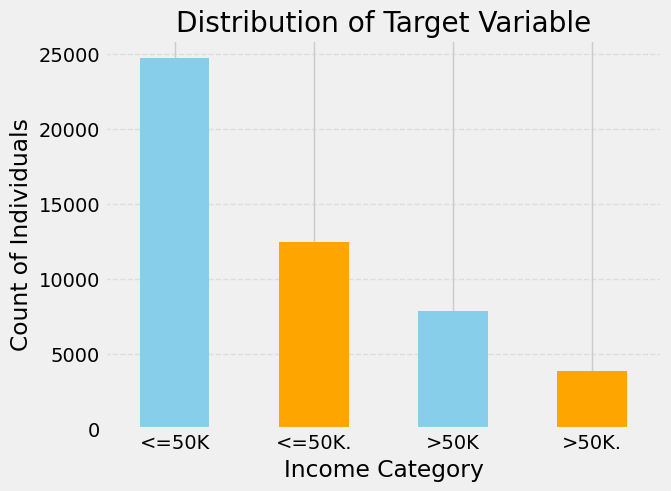

In [443]:
df_1['income'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Target Variable')
plt.xlabel('Income Category')
plt.ylabel('Count of Individuals')
plt.xticks(rotation=0)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [444]:
# Fix inconsistency in target variable values
df_1['income'] = df_1['income'].str.replace('<=50K.', '<=50K')
df_1['income'] = df_1['income'].str.replace('>50K.', '>50K')

print("Target variable value unique classes:")
print(df_1['income'].unique())

Target variable value unique classes:
['<=50K' '>50K' None]


In [445]:
# Create a copy of the combined dataset to work on
df = df_1.copy()

# Convert column names to lowercase and replace spaces and slashes with underscores
# This makes column names easier to reference in code
df.columns = [column.lower().replace(" ", "_").replace("/", "_") for column in df.columns]

In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48843 entries, 0 to 48842
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48843 non-null  object 
 1   workclass       46043 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   education       48842 non-null  object 
 4   education_num   48842 non-null  float64
 5   marital_status  48842 non-null  object 
 6   occupation      46033 non-null  object 
 7   relationship    48842 non-null  object 
 8   race            48842 non-null  object 
 9   sex             48842 non-null  object 
 10  capital_gain    48842 non-null  float64
 11  capital_loss    48842 non-null  float64
 12  hours_per_week  48842 non-null  float64
 13  native_country  47985 non-null  object 
 14  income          48842 non-null  object 
dtypes: float64(5), object(10)
memory usage: 5.6+ MB


In [447]:
from scipy import stats

# Define numerical columns explicitly
num_cols = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

# Ensure numerical columns are numeric.
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN in numerical columns 
df = df.dropna(subset=num_cols)

# Calculate summary statistics
summary_stats = {
    'Mean': df[num_cols].mean(),
    'Median': df[num_cols].median(),
    'Mode': df[num_cols].mode().iloc[0],
    'Standard Deviation': df[num_cols].std(),
    'Skewness': df[num_cols].skew()
}

# Create summary DataFrame
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics DataFrame
print("\n=== Summary Statistics for Numerical Columns ===")
summary_df



=== Summary Statistics for Numerical Columns ===


,Mean,Median,Mode,Standard Deviation,Skewness
age,38.643585,37.0,36.0,13.710510,0.557580
fnlwgt,189664.134597,178144.5,203488.0,105604.025423,1.438892
capital_gain,1079.067626,0.0,0.0,7452.019058,11.894659
capital_loss,87.502314,0.0,0.0,403.004552,4.569809
hours_per_week,40.422382,40.0,40.0,12.391444,0.238750


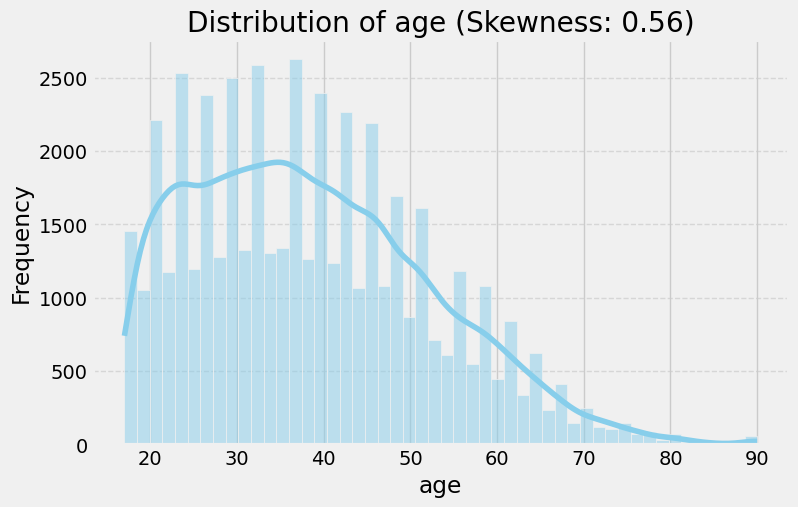

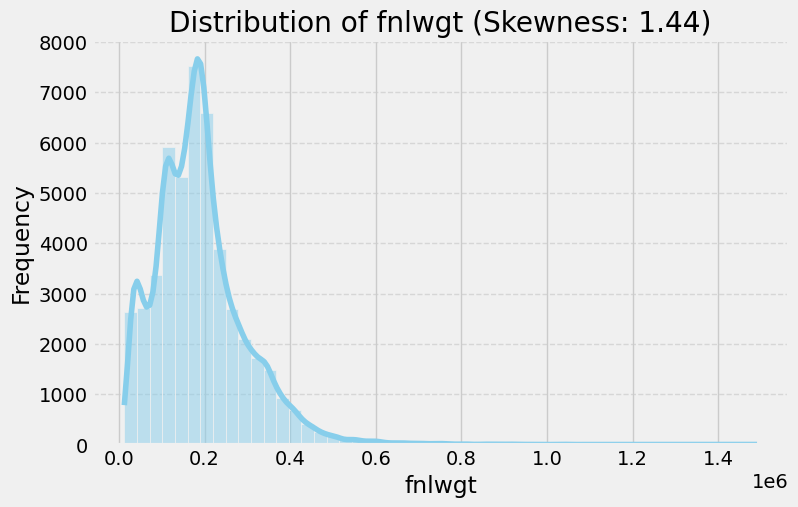

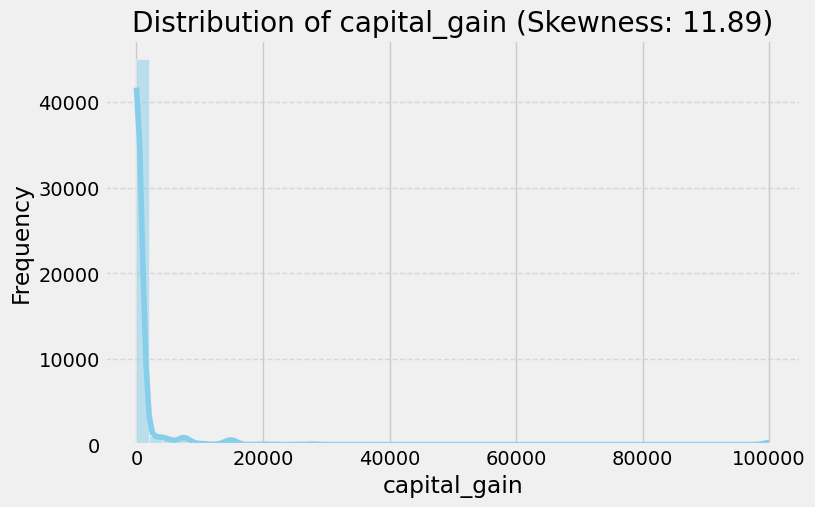

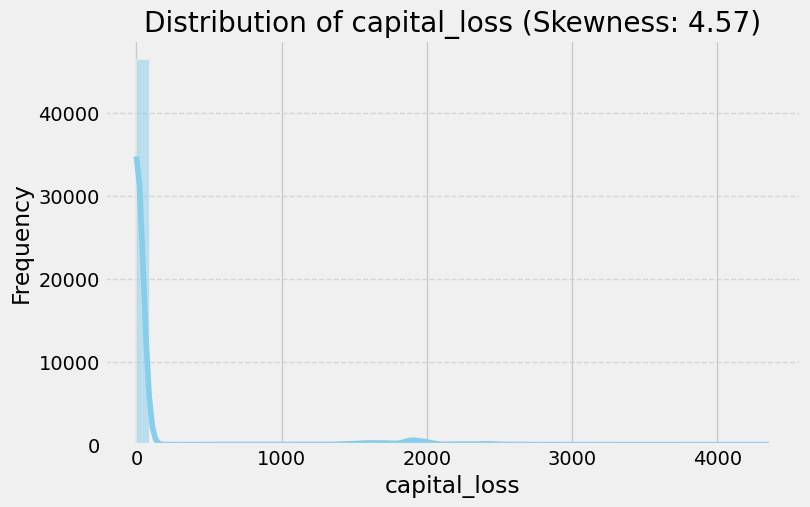

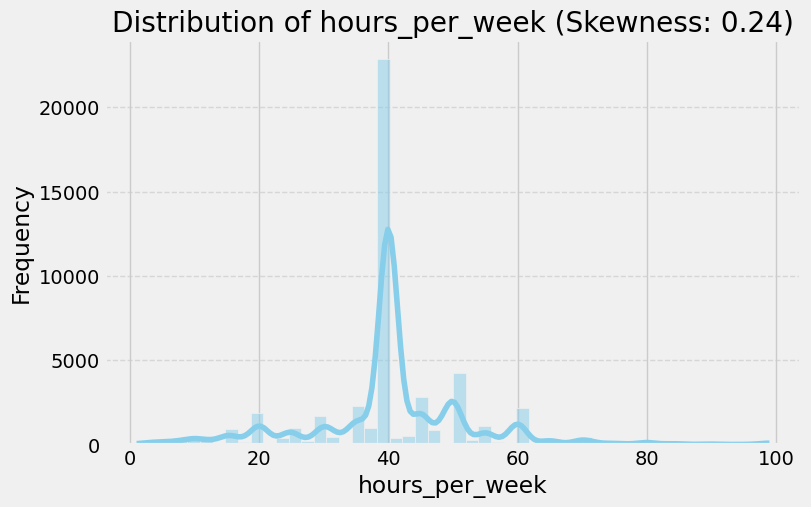

In [448]:
# Plot distribution (Histogram + KDE) for each numerical column
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, color='skyblue', bins=50)
    
    plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Statistical Analysis

- **Age**  
  The average age of employees is about **39 years**, with most people aged close to that.  
  The data is slightly skewed to the right, meaning there are more younger people and a few older ones.

- **Fnlwgt (Final Weight)**  
  The average weight is around **189,664**, but this varies a lot between samples.  
  Some records have much higher weights than the rest, causing a positive skew.

- **Education Number**  
  On average, people have about **10 years of education**.  
  The data is quite balanced, without big differences in the number of years of education.

- **Capital Gain**  
  Most people have **zero capital gain**, but a small number of people have very large gains, making the data highly skewed.

- **Capital Loss**  
  Like capital gain, most people report **zero capital loss**, and only a few have large losses, resulting in a strong right skew.

- **Hours Per Week**  
  The average is about **40 hours per week**, which is a typical full-time schedule.  
  The data is fairly normal, with only a slight tendency for some to work more hours.

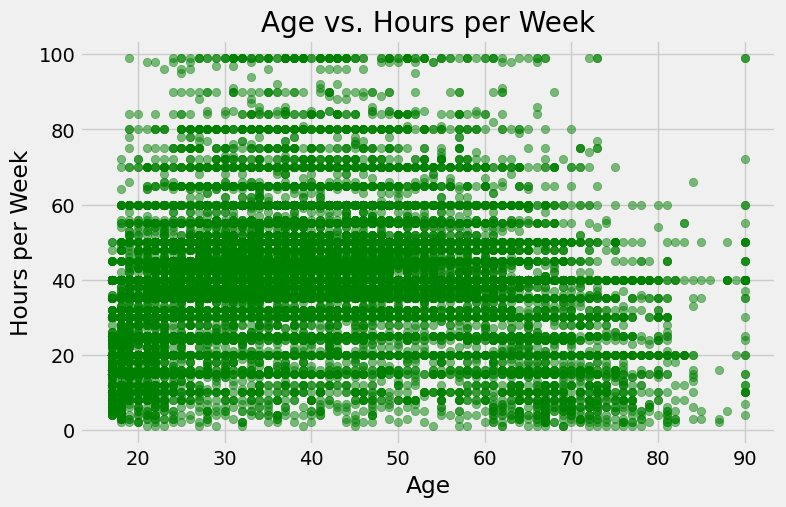

In [449]:
# Scatter Plot: Age vs. Hours per Week
plt.figure(figsize=(8, 5))
plt.scatter(df['age'], df['hours_per_week'], alpha=0.5, color='green')
plt.title('Age vs. Hours per Week')
plt.xlabel('Age')
plt.ylabel('Hours per Week')
plt.show()

#### Insights from Age vs. Hours per Week

- Most work around **40 hours/week**, typical of full-time jobs.
- Dense cluster between **age 20–60** and **30–50 hours/week**.
- Few work extremely long hours (60–100+ hours).
- No strong correlation between age and hours worked.
- Some elderly (70+) still work, mostly part-time or moderate hours.

In [450]:
# Compute correlation matrix
corr = df.select_dtypes(include='number').corr()
corr_df = corr.stack().reset_index()
corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']
corr_df = corr_df[corr_df['Feature_1'] != corr_df['Feature_2']]

# Remove duplicate pairs (keep only one of A–B and B–A)
corr_df['pair'] = corr_df.apply(lambda row: tuple(sorted([row['Feature_1'], row['Feature_2']])), axis=1)
corr_df = corr_df.drop_duplicates(subset='pair').drop(columns='pair').reset_index(drop=True)

# Styling
def highlight_corr(val):
    if val > 0:
        color = 'lightgreen'
    else:
        color = '#ffcccc'
    return f'background-color: {color}; color: #333333; font-weight: bold'

styled_corr_df = corr_df.style.applymap(lambda x: highlight_corr(x) if isinstance(x, (int, float)) else '', subset=['Correlation'])
styled_corr_df

,Feature_1,Feature_2,Correlation
0,age,fnlwgt,-0.076628
1,age,education_num,0.030940
2,age,capital_gain,0.077229
3,age,capital_loss,0.056944
4,age,hours_per_week,0.071558
5,fnlwgt,education_num,-0.038761
6,fnlwgt,capital_gain,-0.003706
7,fnlwgt,capital_loss,-0.004366
8,fnlwgt,hours_per_week,-0.013519
9,education_num,capital_gain,0.125146


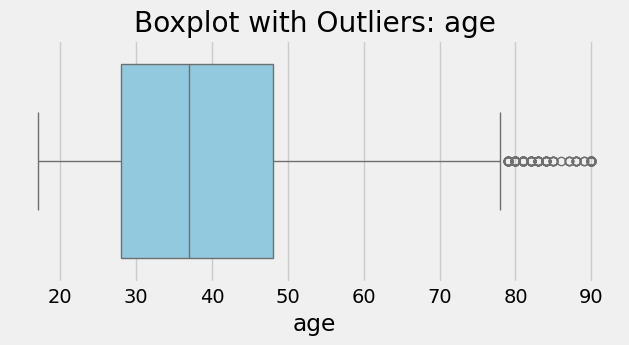

For 'age': We see 216 outlier(s).
 - Values below -2.00 or above 78.00 are considered outliers.


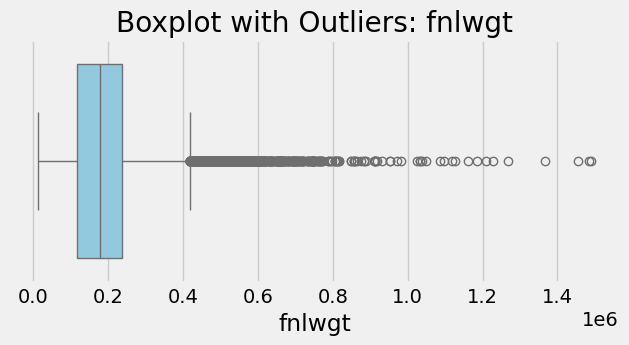

For 'fnlwgt': We see 1453 outlier(s).
 - Values below -62586.75 or above 417779.25 are considered outliers.


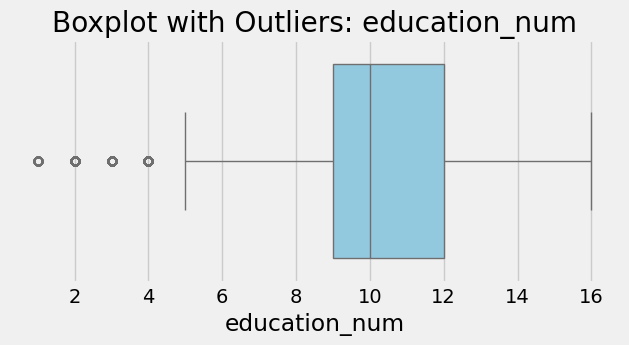

For 'education_num': We see 1794 outlier(s).
 - Values below 4.50 or above 16.50 are considered outliers.


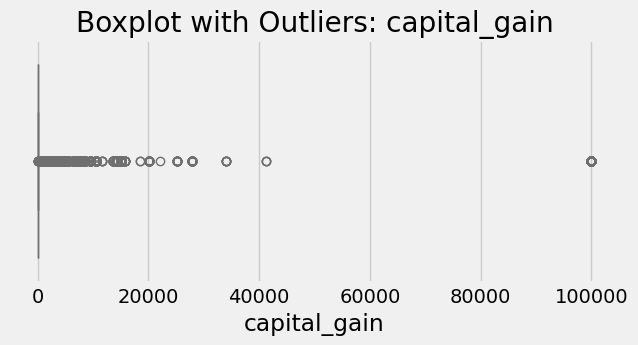

For 'capital_gain': We see 4035 outlier(s).
 - Values below 0.00 or above 0.00 are considered outliers.


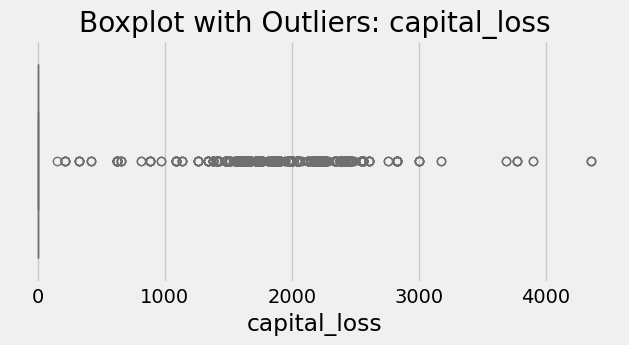

For 'capital_loss': We see 2282 outlier(s).
 - Values below 0.00 or above 0.00 are considered outliers.


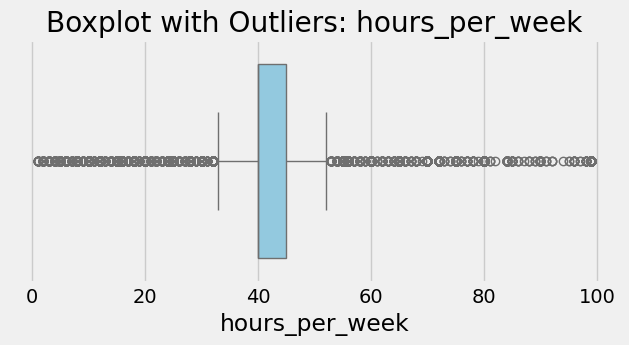

For 'hours_per_week': We see 13496 outlier(s).
 - Values below 32.50 or above 52.50 are considered outliers.


In [451]:
numeric_df = df.select_dtypes(include='number')

# Compute Q1, Q3, and IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Loop through each feature
for col in numeric_df.columns:
    plt.figure(figsize=(7,3))
    sns.boxplot(x=numeric_df[col], color='skyblue')
    plt.title(f'Boxplot with Outliers: {col}')
    plt.show()
    
    # Define outlier conditions
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    
    outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)][col]
    num_outliers = outliers.shape[0]
    
    # Print summary
    if num_outliers > 0:
        print(f"For '{col}': We see {num_outliers} outlier(s).")
        print(f" - Values below {lower_bound:.2f} or above {upper_bound:.2f} are considered outliers.")
    else:
        print(f"For '{col}': No outliers detected.\n")

In [452]:
df = df[df.age != '|1x3 Cross validator'] # Removing this person with unknown age.
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

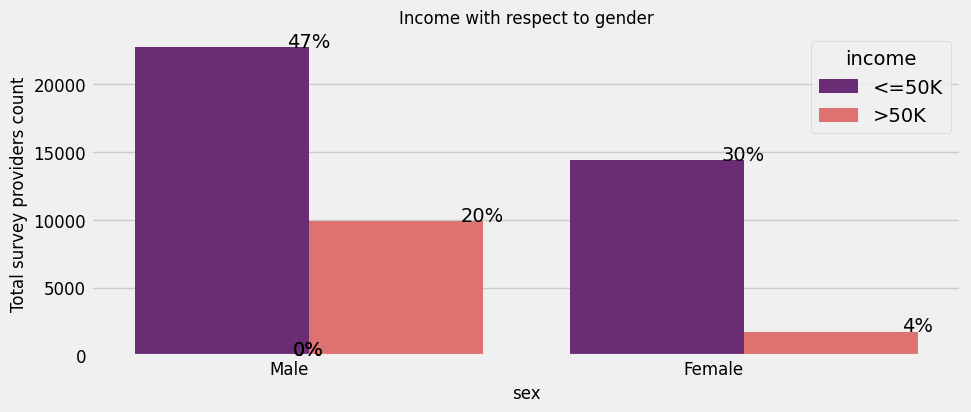

In [453]:
plt.figure(figsize =(10,4))
ax = sns.countplot(data = df, x = 'sex',hue = 'income',palette='magma')
plt.xticks(size =12)
plt.xlabel('sex', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to gender", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# 47% male & 30% female survey takers out of total earn <= 50000. 
# 20% male & 4% female survey takers out of total earn > 50000. 

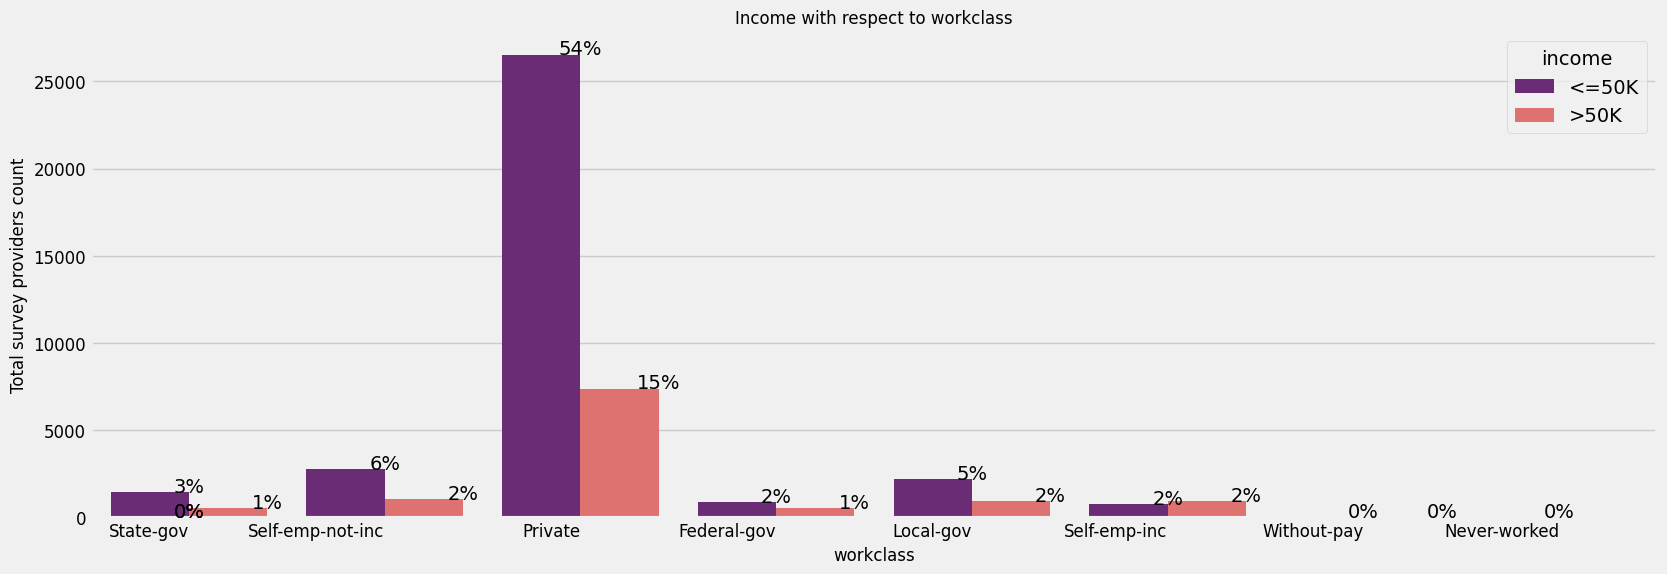

In [454]:
plt.figure(figsize =(18,6))
ax = sns.countplot(data = df, x = 'workclass',hue = 'income',palette='magma')
plt.xticks(size =12)
plt.xlabel('workclass', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to workclass", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# We can see that most people who gave survey worked in private organizations 
# 54% survey takers out of total earn <= 50000. 
# 15% survey takers out of total earn > 50000. 

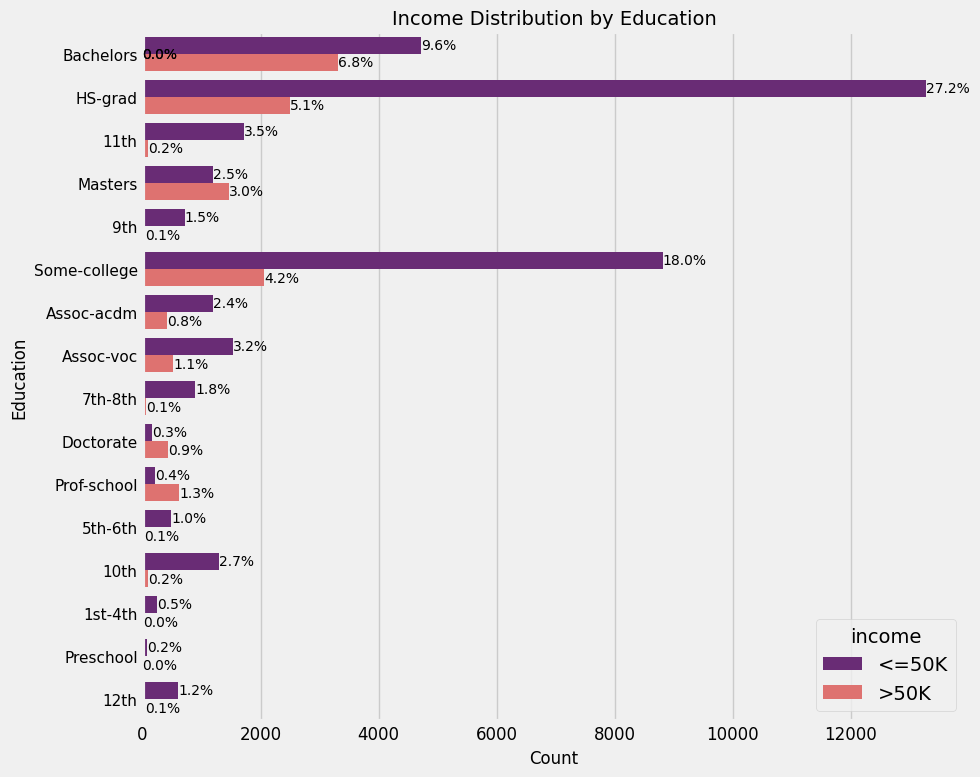

In [455]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data=df, y='education', hue='income', palette='magma')

# Labels and title
plt.ylabel('Education', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.title('Income Distribution by Education', fontsize=14)
plt.yticks(fontsize=11)
plt.xticks(fontsize=12)

# Annotate bars with percentage
total = len(df)
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width / total:.1f}%'
    ax.annotate(percentage, 
                (width, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# We can see that most people who gave survey graduated in higher secondary following with some college.
# 45% survey takers who graduated from a higher secondary & some college out of total earn <= 50000  

#### Data Preprocessing

In [456]:
def find_missing_percent(data):
    """
    Returns a dataframe containing the total missing values and percentage of missing values per column.
    """
    miss_list = []
    for col in data.columns:
        total_missing = data[col].isnull().sum()
        percent_missing = round((total_missing / data.shape[0]) * 100, 2)
        miss_list.append({'ColumnName': col, 'TotalMissingVals': total_missing, 'PercentMissing': percent_missing})
    
    miss_df = pd.DataFrame(miss_list)
    return miss_df

miss_df = find_missing_percent(df)
miss_df

,ColumnName,TotalMissingVals,PercentMissing
0,age,0,0.00
1,workclass,2799,5.73
2,fnlwgt,0,0.00
3,education,0,0.00
4,education_num,0,0.00
5,marital_status,0,0.00
6,occupation,2809,5.75
7,relationship,0,0.00
8,race,0,0.00
9,sex,0,0.00


### Handling Missing Values

- **Mode Imputation:** Replaces missing values with the most frequent category. Simple, but loses information about missingness and slightly biases the distribution.  

- **“Missing” Category:** Replaces missing values with a new category `"Missing"`. Preserves missingness explicitly, keeps original distribution, and allows models to learn from missing entries.  

**Decision:** For our categorical columns, we use the `"Missing"` category instead of mode imputation.

In [457]:
# List of categorical columns with missing values
cat_cols_with_missing = ['workclass', 'occupation', 'native_country']

# Replace NaN with 'Missing'
df[cat_cols_with_missing] = df[cat_cols_with_missing].fillna('Missing')

### Handling Age for Predictive Modeling

- **Decision:** Keep `age` as a continuous variable instead of binning.  

- **Reasoning:**  
  - Binning converts a continuous variable into categories, which **loses information** about subtle differences in age.  
  - Modern machine learning models (like tree-based models, logistic regression, XGBoost) can handle continuous variables effectively.  
  - Keeping `age` continuous allows the model to learn **non-linear relationships** with the target variable without arbitrary cut-offs.  

In [458]:
df['education'].value_counts().sort_values()

education
Preschool          83
1st-4th           247
5th-6th           509
Doctorate         594
12th              657
9th               756
Prof-school       834
7th-8th           955
10th             1389
Assoc-acdm       1601
11th             1812
Assoc-voc        2061
Masters          2657
Bachelors        8025
Some-college    10878
HS-grad         15784
Name: count, dtype: int64

In [459]:
df['education_num'].value_counts().sort_values()

education_num
1.0        83
2.0       247
3.0       509
16.0      594
8.0       657
5.0       756
15.0      834
4.0       955
6.0      1389
12.0     1601
7.0      1812
11.0     2061
14.0     2657
13.0     8025
10.0    10878
9.0     15784
Name: count, dtype: int64

### Handling Education Column for Predictive Modeling

- The dataset has `education` (descriptive labels) and `education_num` (numeric representation of the same information).  
- Since both columns carry the same information, **keeping both is redundant**.  

**Decision:**  
- Drop `education` and keep `education_num` for modeling.  
- Reason: Numeric representation is easier for ML models, preserves order, and avoids redundancy.  
- Categorical variables with clear ordinal relationships can be handled using their numeric codes.

In [460]:
del df['education']

#### Edge case ----->

### Handling Education_num for Predictive Modeling

- The `education_num` column is already ordinal numeric (1–16).  
- Binning it into categories like LOW, MIDDLE, HIGH simplifies it but **loses information**.  
- For predictive modeling, we **keep it as numeric**: this preserves the order, magnitude, and subtle differences, which helps the model learn better.  

**Recommendation:**  
- Use `education_num` as-is for modeling.  
- Only use binned categories for analysis or visualization if needed.

### Dropping the `fnlwgt` Column

- The `fnlwgt` column represents the **final weight**, i.e., the number of people the census believes each entry represents.  
- This column **does not carry predictive information** about a person's income.  
- Keeping it may **add noise or redundancy** to the model.  

**Decision:** Drop `fnlwgt` from the dataset to simplify modeling.

In [461]:
del df['fnlwgt']

### Handling `hours_per_week` Column

- The `hours_per_week` column is numeric and represents the **actual number of hours an employee worked in a week**.  
- Although one could bin it (e.g., `<40`, `40`, `>40`), this would **lose information about small variations** in working hours (e.g., 12 vs 14 hours).  
- For predictive modeling, it is better to **keep this column continuous**, as ML models can naturally learn the relationship between hours worked and income.  

**Decision:** Keep `hours_per_week` as a continuous numeric variable for modeling.

In [462]:
df["race"].value_counts()

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64

### Handling `race` Column `workclass` and `country` Columns

- The `race` column is categorical, with values such as `White`, `Black`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Other`.  
- Although most of the dataset is `White` (~41,000 entries), this column can still carry **important predictive information** for income.  
- For modeling, we should **keep it as a categorical variable** and encode it appropriately:  
  - **One-Hot Encoding** is recommended to allow the model to learn patterns for each race category.  
- Avoid combining categories unless there is a **domain-specific reason**; doing so may **lose predictive signal**.  

#### ---------------
- The `workclass` column is categorical, with values like `Private`, `Self-emp`, `Government`, etc.  
- Although most entries are `Private`, this column may still carry **predictive information** about income.  
- Recommendation: **Keep it as categorical** and encode using **one-hot encoding**.  
- Avoid combining categories unless there is a clear domain reason, to prevent losing predictive signal.  

#### ----------------
- The `country` column is categorical, with most entries being `United-States`.  
- Rare countries could be grouped into an `"Other"` category to reduce sparsity, but **do not remove the column**, as it may influence income predictions.  
- Recommendation: **Keep it as categorical**, encode using **one-hot encoding**, optionally group all non-US countries into `"Other"` for simplicity.  

In [463]:
df["occupation"].value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Missing              2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

### Handling `occupation` Column

- The `occupation` column has multiple categories, some very rare (e.g., `Priv-house-serv`, `Armed-Forces`).  
- Rare categories are grouped into `"Other"` to reduce sparsity.  
- Optionally, managerial and professional roles (`Exec-managerial`, `Prof-specialty`) can be labeled as `"Leader"` for interpretability, while all others are `"Not Leader"`.  
- Missing values are handled as a separate `"Missing"` category.  
- After grouping, encode using one-hot encoding for predictive modeling.

In [464]:
# Define leader occupations
leader_roles = ['Exec-managerial', 'Prof-specialty']

# Define rare occupations threshold (e.g., less than 500 entries)
rare_threshold = 500

# Count the frequency of each occupation
occ_counts = df['occupation'].value_counts()

# Function to map occupations
def map_occupation(x):
    if x in leader_roles:
        return 'Leader'
    elif x not in leader_roles and occ_counts[x] < rare_threshold:
        return 'Other'
    elif pd.isna(x) or x == 'Missing':
        return 'Missing'
    else:
        return 'Not Leader'

# Apply mapping
df['occupation_grouped'] = df['occupation'].apply(map_occupation)
df = df.drop(columns=['occupation'])

In [465]:
df['marital_status'].value_counts()

marital_status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

### Handling `marital_status` Column

- The `marital_status` column has multiple categories, some very rare (e.g., `Married-AF-spouse`).  
- We can group them into broader categories:  
  - `"Married"`: `Married-civ-spouse`, `Married-spouse-absent`, `Married-AF-spouse`  
  - `"Not-Married"`: `Never-married`, `Divorced`, `Separated`, `Widowed`  
- This reduces sparsity while retaining predictive information.  
- After grouping, encode using one-hot or label encoding for modeling.

In [466]:
# Define mapping
married_status = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
not_married_status = ['Never-married', 'Divorced', 'Separated', 'Widowed']

# Function to map marital status
def map_marital_status(x):
    if x in married_status:
        return 'Married'
    elif x in not_married_status:
        return 'Not-Married'
    else:
        return 'Missing'  # if there are any missing values

# Apply mapping
df['marital_status_grouped'] = df['marital_status'].apply(map_marital_status)
df = df.drop(columns=['marital_status'])

In [467]:
# Iterate through categorical columns and print unique values
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(f"Unique Values: {df[col].unique()}\n")

Column: workclass
Unique Values: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Missing' 'Self-emp-inc' 'Without-pay' 'Never-worked']

Column: relationship
Unique Values: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

Column: race
Unique Values: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

Column: sex
Unique Values: ['Male' 'Female']

Column: native_country
Unique Values: ['United-States' 'Cuba' 'Jamaica' 'India' 'Missing' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands']

Column: income
Unique Values: ['<=50K' '>50K']

Column: occupation_group

In [468]:
df_processed = df.copy()

# Initialize label encoder
le = LabelEncoder()

# Lists to track encoding types
label_encoded_cols = []
onehot_encoded_cols = []

# Iterate through all categorical columns
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() <= 2:
        # Binary column → Label Encoding
        df_processed[col] = le.fit_transform(df[col])
        label_encoded_cols.append(col)
    else:
        # Multi-class column → One-Hot Encoding
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(columns=[col], inplace=True)
        onehot_encoded_cols.extend(dummies.columns.tolist())

# Print summary
print("Label Encoded Columns:", label_encoded_cols)
print("One-Hot Encoded Columns:", onehot_encoded_cols)

Label Encoded Columns: ['sex', 'income', 'marital_status_grouped']
One-Hot Encoded Columns: ['workclass_Local-gov', 'workclass_Missing', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White', 'native_country_Canada', 'native_country_China', 'native_country_Columbia', 'native_country_Cuba', 'native_country_Dominican-Republic', 'native_country_Ecuador', 'native_country_El-Salvador', 'native_country_England', 'native_country_France', 'native_country_Germany', 'native_country_Greece', 'native_country_Guatemala', 'native_country_Haiti', 'native_country_Holand-Netherlands', 'native_country_Honduras', 'native_country_Hong', 'native_country_Hungary', 'native_country_India', 'native_country_Iran', 'na

Log Transformation for Skewed Features

Columns: capital_gain, capital_loss

Problem:

These columns are heavily right-skewed with some extreme high values (outliers).

Solution:

Apply log transformation using np.log1p() → log(1 + x) to compress large values while keeping zeros intact.

Benefits / Insights:

Reduces skew and balances the distribution.

Compresses the effect of extreme values.

In [469]:
df_processed['capital_gain_log'] = np.log1p(df_processed['capital_gain'])
df_processed['capital_loss_log'] = np.log1p(df_processed['capital_loss'])
df_processed['net_capital_log'] = df_processed['capital_gain_log'] - df_processed['capital_loss_log']

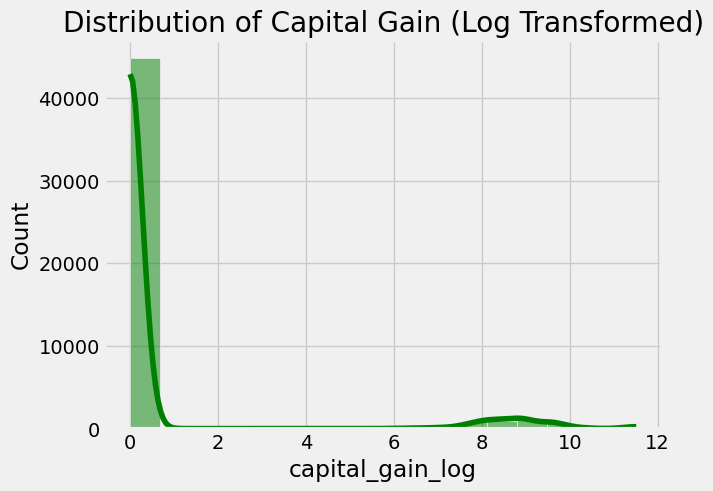

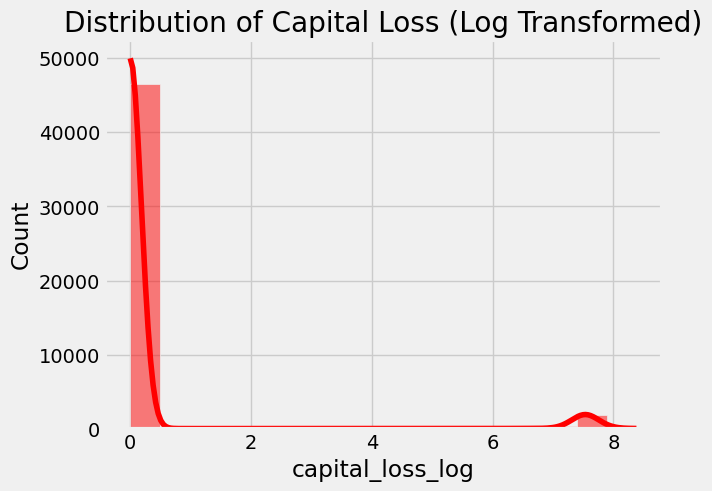

In [470]:
sns.histplot(df_processed['capital_gain_log'], kde=True, color='green')
plt.title('Distribution of Capital Gain (Log Transformed)')
plt.show()

sns.histplot(df_processed['capital_loss_log'], kde=True, color='red')
plt.title('Distribution of Capital Loss (Log Transformed)')
plt.show()


In [471]:
df_processed.head(10)

,age,education_num,sex,capital_gain,capital_loss,hours_per_week,income,marital_status_grouped,workclass_Local-gov,workclass_Missing,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native_country_Canada,native_country_China,native_country_Columbia,native_country_Cuba,native_country_Dominican-Republic,native_country_Ecuador,native_country_El-Salvador,native_country_England,native_country_France,native_country_Germany,native_country_Greece,native_country_Guatemala,native_country_Haiti,native_country_Holand-Netherlands,native_country_Honduras,native_country_Hong,native_country_Hungary,native_country_India,native_country_Iran,native_country_Ireland,native_country_Italy,native_country_Jamaica,native_country_Japan,native_country_Laos,native_country_Mexico,native_country_Missing,native_country_Nicaragua,native_country_Outlying-US(Guam-USVI-etc),native_country_Peru,native_country_Philippines,native_country_Poland,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,occupation_grouped_Missing,occupation_grouped_Not Leader,occupation_grouped_Other,capital_gain_log,capital_loss_log,net_capital_log
0,39.0,13.0,1,2174.0,0.0,40.0,0,1,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,7.684784,0.0,7.684784
1,50.0,13.0,1,0.0,0.0,13.0,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.000000,0.0,0.000000
2,38.0,9.0,1,0.0,0.0,40.0,0,1,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0.000000,0.0,0.000000
3,53.0,7.0,1,0.0,0.0,40.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0.000000,0.0,0.000000
4,28.0,13.0,0,0.0,0.0,40.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.000000
5,37.0,14.0,0,0.0,0.0,40.0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,

### **Data Preprocessing – Continuous Variables**

* **Continuous Columns:** `age`, `hours_per_week`, `capital_gain`, `capital_loss`

* **Scaling:** Not required at this stage since we are not modeling yet. Scaling can be applied later if needed.

* **Outliers:**

  * Observed in `capital_gain` and `capital_loss`.
  * Options: leave as-is (tree-based models are robust) or cap extreme values (Winsorization) if needed. For now, we can leave them.